In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from fractions import Fraction

In [181]:
class MarkovChain:
    """
    class to simulate a Markov chain + plot some graphs
    """
    def __init__(self):
        """
        """
        print("WARNING!!! ")
        self.history = dict()
        for key in self.G.nodes:
            self.history[key] = 0 
        self.iterations = 0
        self.states = []
    
    def random_step(self, number_of_steps=1):
        for i in range(number_of_steps):
            u = np.random.rand()
            v = self.state
            for vp in self.G.neighbors(v):
                if u <= self.G.edges[v, vp]['weight']:
                    self.state = vp
                    self.history[self.state] += 1
                    self.states.append(vp)
                    break
                else:
                    u -= self.G.edges[v, vp]['weight']
            self.iterations += 1

    def disp(self, show_weight=True, save_name=None, draw_history=False):
        fig = plt.figure()
        plt.title('After {} transitions'.format(self.iterations))
        colors = ['#ff8888' if self.state==key else '#00ff00' for key in self.G.nodes]
        if show_weight:
            labels = nx.get_edge_attributes(self.G, 'weight')
            for key in labels:
                labels[key] = str(Fraction(labels[key]).limit_denominator(1000))
            nx.draw_networkx_edge_labels(self.G, self.pos, edge_labels=labels)
        if draw_history:
            labels = dict()
            for key in self.G.nodes:
                labels[key] = '     {} {:3d}'.format(key, int(self.history[key]))
            nx.draw(self.G, pos=self.pos, node_color=colors,
                    with_labels=True, labels=labels, font_familly="bold", font_color='b')
        else:
            nx.draw(self.G, pos=self.pos, node_color=colors, with_labels=True)
        if save_name is not None:
            if save_name == 'default':
                save_name = 'outputs/random_walk_{}.pdf'.format(self.iterations)
            plt.savefig(save_name) #, bbox_inches='tight')
            
class RandomWalk(MarkovChain):
    """
    Class to simulate 
    """
    def __init__(self, G):
        self.G = G
        self.pos = nx.kamada_kawai_layout(G)
        self.state = [key for key in G.nodes][0]
        for v in G.nodes:
            for vp in G.neighbors(v):
                self.G.edges[v,vp]['weight']=1/G.out_degree(v)
        super().__init__()

WARNING!!! 


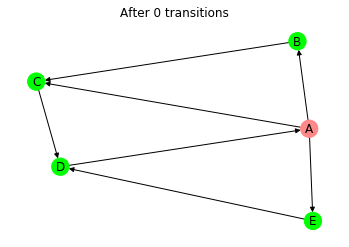

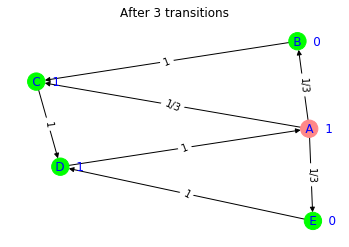

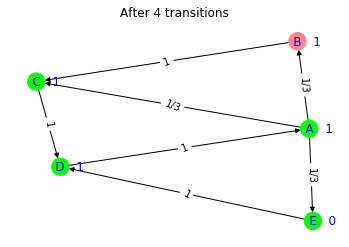

In [182]:
np.random.seed(1) # to ensure reproducibility

G = nx.DiGraph()
G.add_edge('A', 'B', weight=1)
G.add_edge('A', 'C', weight=1)
G.add_edge('B', 'C', weight=1)
G.add_edge('C', 'D', weight=1)
G.add_edge('D', 'A', weight=1)
G.add_edge('A', 'E', weight=1)
G.add_edge('E', 'D', weight=1)
#G.add_edge('D', 'E', weight=1)
#G.add_edge('E', 'C', weight=1)

G = RandomWalk(G)
G.disp(show_weight=False, save_name='outputs/initial_graph.pdf')
for i in range(5):
    G.random_step()
    G.disp(save_name='default', draw_history=True)
G.random_step(95)
G.disp(save_name='default', draw_history=True)
G.random_step(900)
G.disp(save_name='default', draw_history=True)


In [270]:

def B(i):
    return 'M-{}'.format(i)
def E(i):
    return 'A-{}'.format(i)

class Inventory(MarkovChain):
    """
    Defines a Markov chain corresponding to a transition matrix. 
    """
    def __init__(self, D, A, max_store=10):
        """
        D = demand (vectors of proba. D[i] = proba(demand=i) Should sum to 1)
        A = action. - Positive A = buy always A
                    - Negative A = fill up to -A
        max_store 
        """
        self.G = nx.DiGraph()
        self.pos = dict([])
        for i in range(max_store+1):
            self.G.add_node(B(i))
            self.G.add_node(E(i))
            self.pos[B(i)] = np.array([2*i,0])
            self.pos[E(i)] = np.array([2*i,1])
        for i in range(max_store+1):
            self.G.add_edge(B(i), E(max(i-len(D),0)), weight=sum(D[i:]))
            for j in range(0,min(i,len(D)-1)):
                self.G.add_edge(B(i), E(i-j), weight=D[j])
        for i in range(max_store+1):
            if A>0: # We always buy A
                self.G.add_edge(E(i), B(min(i+A, max_store)), weight=1)
            else:
                self.G.add_edge(E(i), B(max(i, -A)), weight=1)
        # cleaning: 
        weights = nx.get_edge_attributes(self.G, 'weight')
        for v,vp in [edge for edge in self.G.edges]:
            if weights[(v, vp)] <= 1e-5: 
                self.G.remove_edge(v, vp)
        self.state = B(max_store)
        print(self.G.nodes)
        super().__init__()
        
    def draw_trajectory(self):
        states = [int(s[2:]) for s in self.states]
        plt.plot(states)
        plt.xlim([0,300])
        plt.xlabel('Time $t$')
        plt.xlabel('Stock level $X_t$')
        
    def plot_history(self):
        histo = self.history
        x = np.arange(0, int(len(histo)/2))
        hist = [histo[B(i)] for i in x]
        hist2 = [histo[E(i)] for i in x]
        plt.bar(x, hist)
        plt.bar(x, hist2)
        plt.legend(['X_{2t} (morning)', 'X_{2t+1} (end of afternoon)'])
        
    def plot_all(self, name=None):
        fig =  plt.figure()
        fig.set_size_inches((15,5))
        plt.subplot(1,2,1)
        self.draw_trajectory()
        plt.subplot(1,2,2)
        self.plot_history()
        if name is not None:
            plt.savefig(name, bbox_inches='tight')

['M-0', 'A-0', 'M-1', 'A-1', 'M-2', 'A-2', 'M-3', 'A-3', 'M-4', 'A-4', 'M-5', 'A-5', 'M-6', 'A-6', 'M-7', 'A-7', 'M-8', 'A-8', 'M-9', 'A-9', 'M-10', 'A-10', 'M-11', 'A-11', 'M-12', 'A-12', 'M-13', 'A-13', 'M-14', 'A-14', 'M-15', 'A-15', 'M-16', 'A-16', 'M-17', 'A-17', 'M-18', 'A-18', 'M-19', 'A-19', 'M-20', 'A-20', 'M-21', 'A-21', 'M-22', 'A-22', 'M-23', 'A-23', 'M-24', 'A-24', 'M-25', 'A-25', 'M-26', 'A-26', 'M-27', 'A-27', 'M-28', 'A-28', 'M-29', 'A-29', 'M-30', 'A-30', 'M-31', 'A-31', 'M-32', 'A-32', 'M-33', 'A-33', 'M-34', 'A-34', 'M-35', 'A-35', 'M-36', 'A-36', 'M-37', 'A-37', 'M-38', 'A-38', 'M-39', 'A-39', 'M-40', 'A-40']
WARNING!!! 


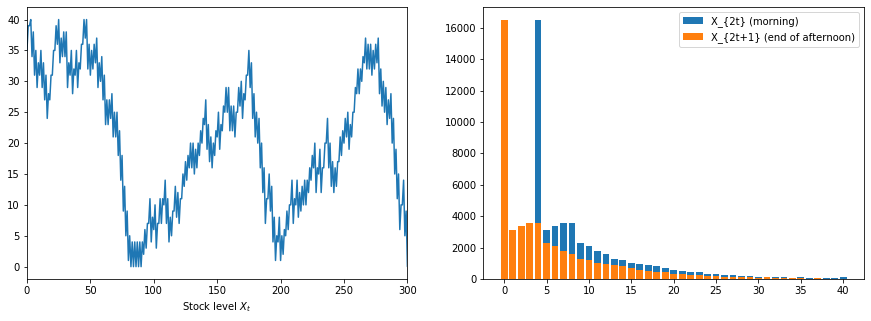

In [271]:
inventory = Inventory(D=np.ones(11)/11, A=4, max_store=40)
inventory.random_step(100000)
inventory.plot_all(name='inventory_strategy_+4.pdf')

['M-0', 'A-0', 'M-1', 'A-1', 'M-2', 'A-2', 'M-3', 'A-3', 'M-4', 'A-4', 'M-5', 'A-5', 'M-6', 'A-6', 'M-7', 'A-7', 'M-8', 'A-8', 'M-9', 'A-9', 'M-10', 'A-10']
WARNING!!! 


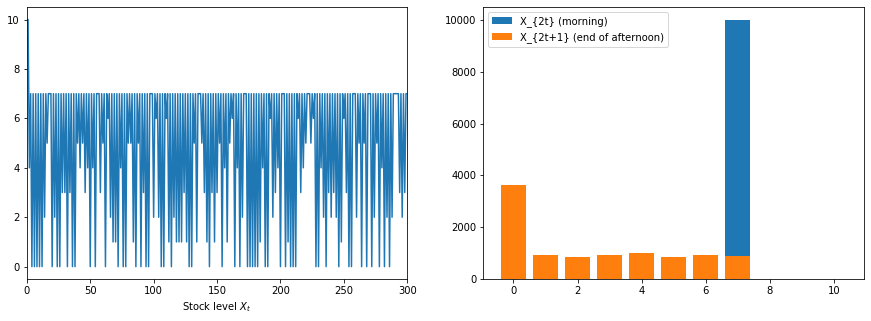

In [272]:
inventory = Inventory(D=np.ones(11)/11, A=-7, max_store=10)
inventory.random_step(20000)
inventory.plot_all(name='inventory_treshold_7.pdf')